In this sample project, I am scraping data from truecar.com about used cars and using it to train a Machine Learning model for estimating the price of a new car in the used car market. In this project, I am mining data using the requests and BeautifulSoup library for <a href='#mining'>web scraping</a>. I am also utilizing the <a href='#MYSQL'>MYSQL</a> library to create a dataset and employing the <a href='#ML'>decision tree algorithm</a> in Scikit-Learn to estimate the presumptive car price. This model is trained using two features, so <a href='#acc'>accuracy</a> may not be achievable.

#Note: This code is a sample project:) 

<a id = "mining"></a>
Mining data and save in database:

In [6]:
import re
from bs4 import BeautifulSoup
import requests

In [9]:
#creat url address
car_brand = 'toyota'
car_model ='corolla'
def creat_url(page):
    page = str(page)
    url_truecar = 'https://www.truecar.com/used-cars-for-sale/listings/' + car_brand+'/'+ car_model +'/?page='+ page
    return url_truecar


In [52]:
#Request
import pandas as pd
import numpy as np
import seaborn as sns

new_data=[]
for n in range(1 , 100):
    url_truecar = creat_url(n)
    page_truecar = requests.get(url_truecar)

#Cooking soup
    soup = BeautifulSoup(page_truecar.text, 'html.parser')


    val = soup.find_all(attrs={
                    'data-test': ["vehicleCardYearMakeModel", "vehicleCardPricingBlockPrice", 'vehicleMileage']})
    
    for e in range(len(val)//3):

        name = (val[(3*e)].text)
        name = name.split()
        year = int(name[0][-4:]) # 2020
        car_name = str(name[2])  # corla
        list_price = (val[((3*e)+1)].text)
        list_price = list_price.split('$')
        price = list_price[1]

        price = price.replace(',', '')
        price = int(price)

        list_miles = (val[((3*e)+2)].text)

        list_miles = list_miles.split(' ')
        miles = list_miles[0]
        miles = miles.replace(',', '')
        miles = int(miles)
        new_data.append({"year": year, "miles": miles , "price": price})    
new_df = pd.DataFrame(new_data)

<a id = "MYSQL"></a>
check database and saving new data on it

In [3]:
import mysql.connector
from sqlalchemy import create_engine

db_config = {
    "host": "localhost",
    "user": "root",
    "password": "Password",
    "database": "usedcars",
}

conn = mysql.connector.connect(**db_config)

table_name = "Toyota corolla"

sql_query = "SELECT * FROM `Toyota corolla`"
#Read database
df = pd.read_sql(sql_query, conn)
#Append new data
df = df.append(new_df, ignore_index=True)
#Uptodate Database
engine = create_engine(f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}")
df.to_sql(name='Toyota corolla', con=engine, if_exists='append', index=False)

conn.close()

print('database Uptodated')


database Uptodated


/var/folders/wk/yxn7qct55cs0rhw_f9bs0m280000gn/T/ipykernel_2490/3960276781.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


<a id = "ML"></a>
make a dataset and train the ML model:

In [4]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings

# Suppress the RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn.utils.extmath")


# Assuming 'df' is your DataFrame
X = df.drop("price", axis=1) # Features without the target
y = df["price"]  # Target feature

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=0)

# Standardize features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


ACC = []
max_depth_options = [10,12,14,16,18,20,22,24,26,28,30]
for trees in max_depth_options:
    dt = DecisionTreeClassifier(max_depth = trees,
                                random_state = 0)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_valid)
    ACC.append(accuracy_score(y_valid, y_pred))

ACC

[0.08582834331337326,
 0.12874251497005987,
 0.18363273453093812,
 0.2774451097804391,
 0.3662674650698603,
 0.45109780439121755,
 0.5179640718562875,
 0.5718562874251497,
 0.6027944111776448,
 0.6147704590818364,
 0.6237524950099801]

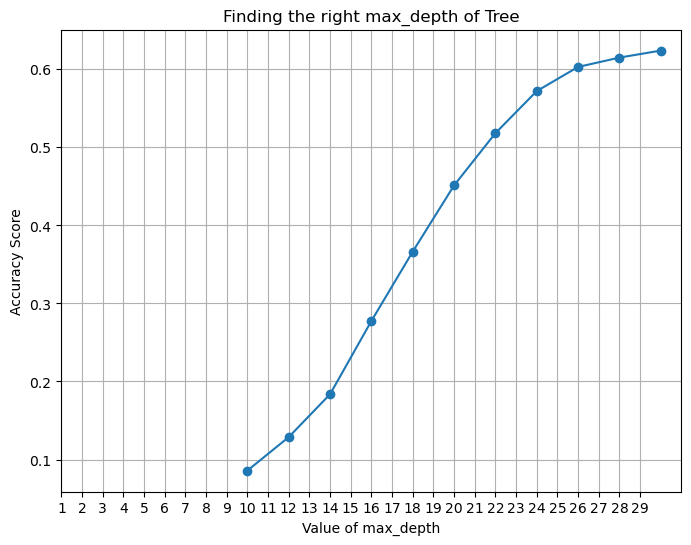

In [11]:
plt.figure(figsize=(8,6))
plt.plot(max_depth_options, ACC, marker = "o")
plt.xlabel("Value of max_depth")
plt.ylabel("Accuracy Score")
plt.title("Finding the right max_depth of Tree")
plt.xticks(range(1,30))
plt.grid()

In [14]:
print("The best max_depth is:", max_depth_options[np.argmax(ACC)])
max_depth = max_depth_options[np.argmax(ACC)]

The best max_depth is: 30


max_features:

In [15]:
ACC = []
max_features_options = ['auto',None,'sqrt',0.95,0.75,0.5,0.25,0.10]
for trees in max_features_options:
    dt = DecisionTreeClassifier(max_features = trees,
                                max_depth = max_depth ,
                                random_state = 0)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_valid)
    ACC.append(accuracy_score(y_valid, y_pred))

ACC

/Users/shahab/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[0.625748502994012,
 0.6237524950099801,
 0.625748502994012,
 0.625748502994012,
 0.625748502994012,
 0.625748502994012,
 0.625748502994012,
 0.625748502994012]

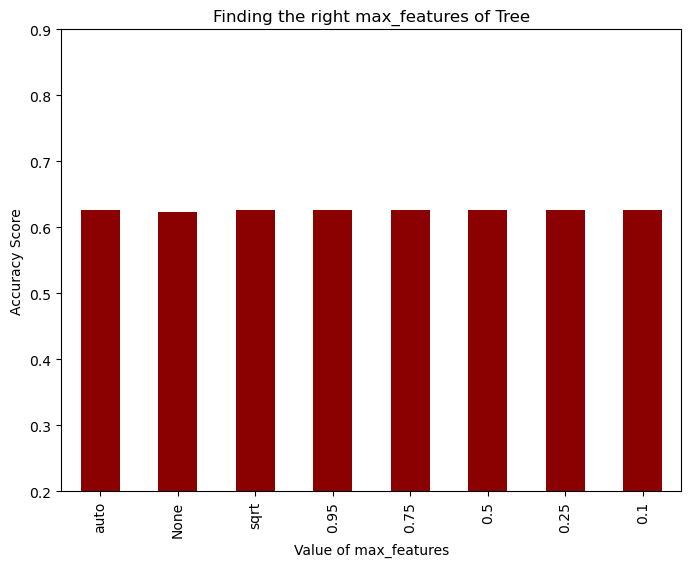

In [16]:
plt.figure(figsize=(8,6))
pd.Series(ACC, max_features_options).plot(kind="bar",color="darkred",ylim=(0.2,0.9))
plt.xlabel("Value of max_features")
plt.ylabel("Accuracy Score")
plt.title("Finding the right max_features of Tree")
plt.show()

In [17]:
print("The best max_features is:", max_features_options[np.argmax(ACC)])
max_features = max_features_options[np.argmax(ACC)]

The best max_features is: auto


min_samples_leaf:

In [63]:
ACC = []
min_samples_leaf_options = [5,10,15,20,25,30,35,40,45,50]
for trees in min_samples_leaf_options:
    dt = DecisionTreeClassifier(min_samples_leaf = trees,
                                max_depth = max_depth,
                                max_features = max_features,
                                random_state = 0)

    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_valid)
    ACC.append(accuracy_score(y_valid, y_pred))

ACC

/Users/shahab/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shahab/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shahab/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/shahab/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

[0.049523809523809526,
 0.049523809523809526,
 0.049523809523809526,
 0.04380952380952381,
 0.0419047619047619,
 0.0419047619047619,
 0.04,
 0.0419047619047619,
 0.0419047619047619,
 0.0419047619047619]

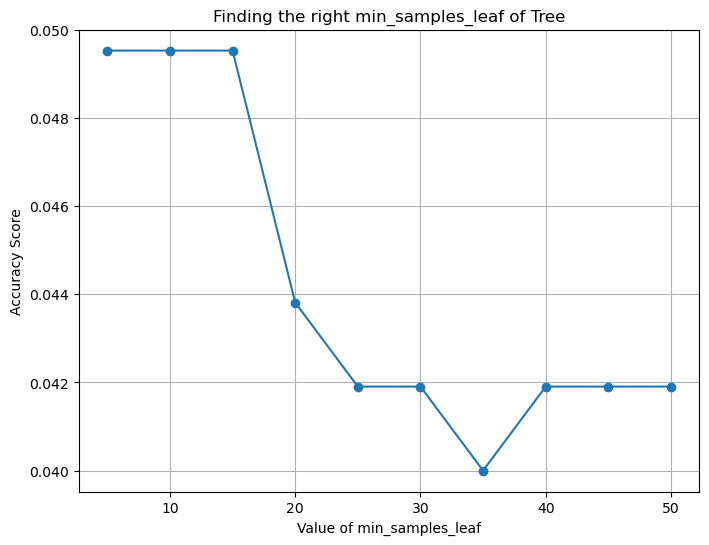

In [64]:
plt.figure(figsize=(8,6))
plt.plot(min_samples_leaf_options, ACC, marker = "o")
plt.xlabel("Value of min_samples_leaf")
plt.ylabel("Accuracy Score")
plt.title("Finding the right min_samples_leaf of Tree")
plt.grid()

In [65]:
print("The best min_samples_leaf is:", min_samples_leaf_options[np.argmax(ACC)])
min_samples = min_samples_leaf_options[np.argmax(ACC)]

The best min_samples_leaf is: 5


<a id = "acc"></a>
The accuracy was checked with test dataset:

In [66]:
dt = DecisionTreeClassifier(min_samples_leaf =  min_samples,
                                max_depth = max_depth,
                                max_features = max_features,
                                random_state = 0)

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred)

print("BestDecision Tree accuracy is: ", acc_dt)

BestDecision Tree accuracy is:  0.03353658536585366


/Users/shahab/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


In [69]:
import pickle
dt_model_file = 'dt_usedcars_model.pkl'
pickle.dump(dt, open(dt_model_file, 'wb'))